# Classification of Experimental Data
I will use this notebook to load the experimental data and use my subimage classifier to predict if the device is in a single dot or a double dot region.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
import glob
import scipy.interpolate
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)

## Loading of the experimental data

### May files
These are 9 useful files May1_i where i = 1...9. The centre gate voltage goes from $-0.6V$ to $-0.76V$ from i=1..9 files. 

(10000, 5)


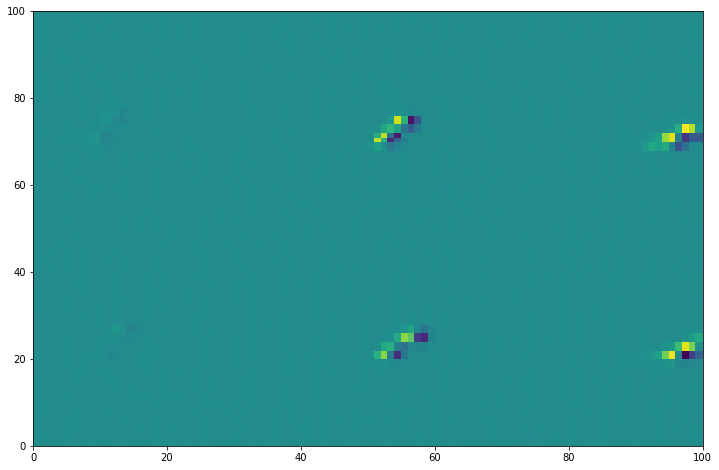

In [37]:
index = 9
filename = "/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/May1_" + str(index) + ".dat"
dat = np.loadtxt(filename)
print(dat.shape)

# values from the data
points = (dat[:,0],dat[:,2])
values = dat[:,3]

V_b1 = np.linspace(np.min(points[0]),np.max(points[0]),100)
V_b2 = np.linspace(np.min(points[1]),np.max(points[1]),100)
XX,YY = np.meshgrid(V_b1,V_b2)

z = scipy.interpolate.griddata(points,values,(XX,YY),method="nearest")
plt.pcolor(np.gradient(z)[1])

In [33]:
## organize the files into a single array to test on CNN
x_test_data = []
for index in range(1,10):
    filename = "/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/May1_" + str(index) + ".dat"
    dat = np.loadtxt(filename)

    # values from the data
    points = (dat[:,0],dat[:,2])
    values = dat[:,3]

    V_b1 = np.linspace(np.min(points[0]),np.max(points[0]),30)
    V_b2 = np.linspace(np.min(points[1]),np.max(points[1]),30)
    XX,YY = np.meshgrid(V_b1,V_b2)

    z = scipy.interpolate.griddata(points,values,(XX,YY),method="nearest") 
    x_test_data.append(z)
x_test_data = np.array(x_test_data)

In [7]:
plt.pcolor(x_test_data[8])

## Testing of the CNN classifier 

In [8]:
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features["x"],[-1,30,30,1]),tf.float32)
    
    conv1 = tf.layers.conv2d(inputs=input_layer,
                            filters=16,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2)
    
    conv2 = tf.layers.conv2d(inputs=pool1,
                            filters=16,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2)
    
    flat = tf.contrib.layers.flatten(inputs=pool2)
    # dense output layer
    out1 = tf.layers.dense(inputs=flat,units=1024,activation=tf.nn.relu)  
    dropout1 = tf.layers.dropout(
      inputs=out1, rate=0.5, training=mode == learn.ModeKeys.TRAIN)
    
    out2 = tf.layers.dense(inputs=dropout1,units=256,activation=tf.nn.relu)  
    dropout2 = tf.layers.dropout(
      inputs=out2, rate=0.5, training=mode == learn.ModeKeys.TRAIN)
    
    out = tf.layers.dense(inputs=dropout2, units=4)
    
    loss = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        loss = tf.losses.mean_squared_error(labels=labels, predictions=out)

    # Configure the training op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # Generate predictions
    predictions= {
        "prob" : out,
        "states" : tf.argmax(out,axis=1)
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)


    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=tf.argmax(labels,axis=1), predictions=predictions["states"])}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [9]:
model_dir = "/Users/sandesh/trained_networks/substate_classifier/"
substate_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,model_dir=model_dir)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1176d0f60>, '_num_worker_replicas': 1, '_service': None, '_task_type': 'worker', '_save_checkpoints_steps': None, '_model_dir': '/Users/sandesh/trained_networks/substate_classifier/', '_keep_checkpoint_max': 5, '_is_chief': True, '_num_ps_replicas': 0, '_tf_random_seed': None, '_save_summary_steps': 100, '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_task_id': 0, '_save_checkpoints_secs': 600}


In [19]:
index = 1
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x" : 1e3*x_test_data[:]},
      y=None,
      num_epochs=1,
      shuffle=False)

predictions = list(substate_classifier.predict(input_fn=test_input_fn))
print("Dot state",[x['states']-1 for x in predictions])


INFO:tensorflow:Restoring parameters from /Users/sandesh/trained_networks/substate_classifier/model.ckpt-750
Dot state [1, 1, 1, 1, 1, 2, 2, 2, 2]


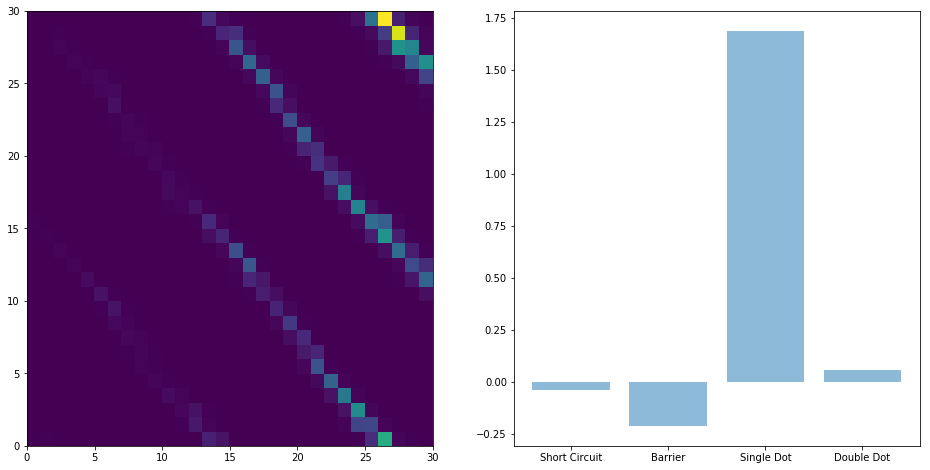

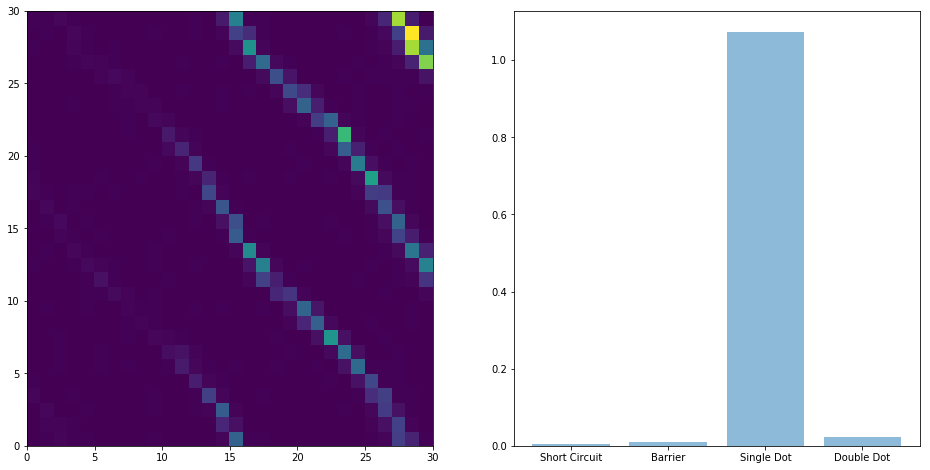

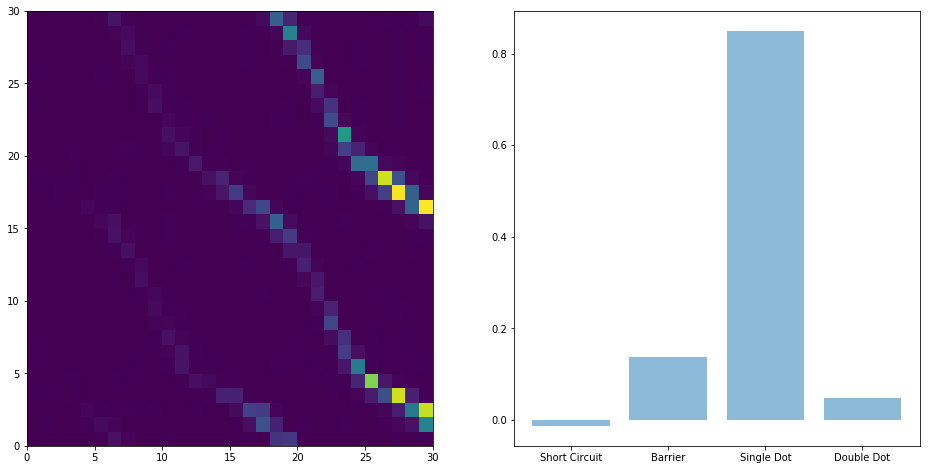

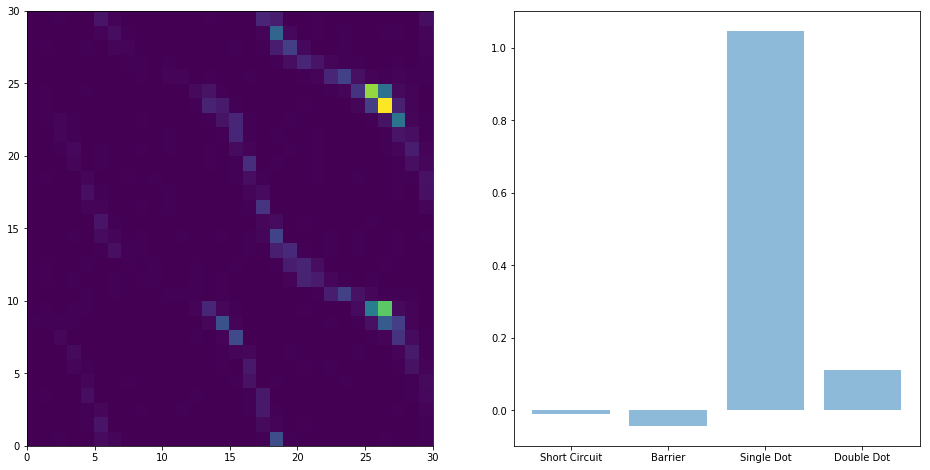

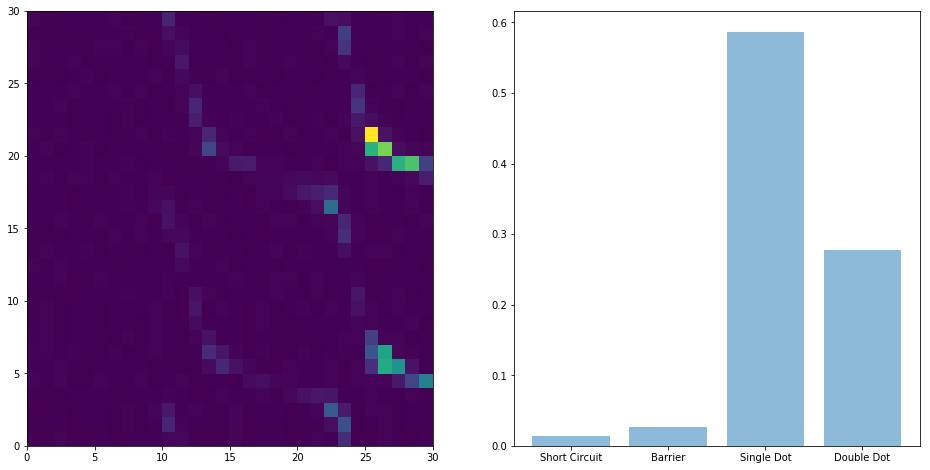

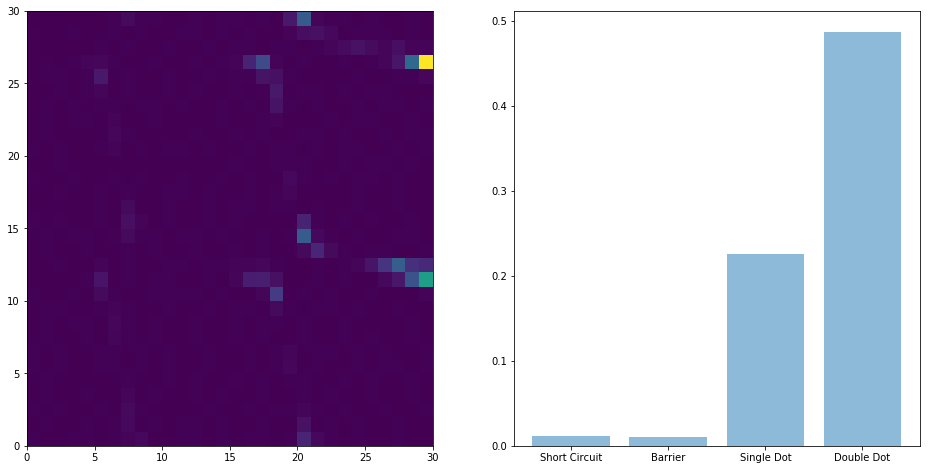

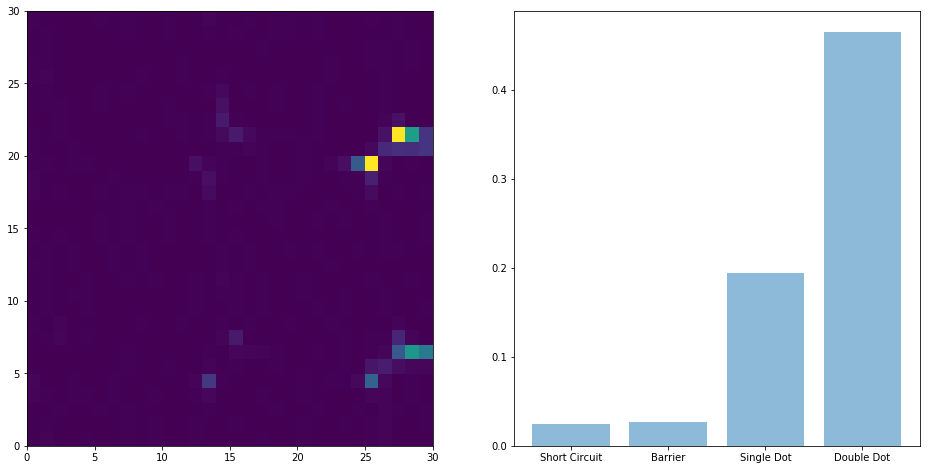

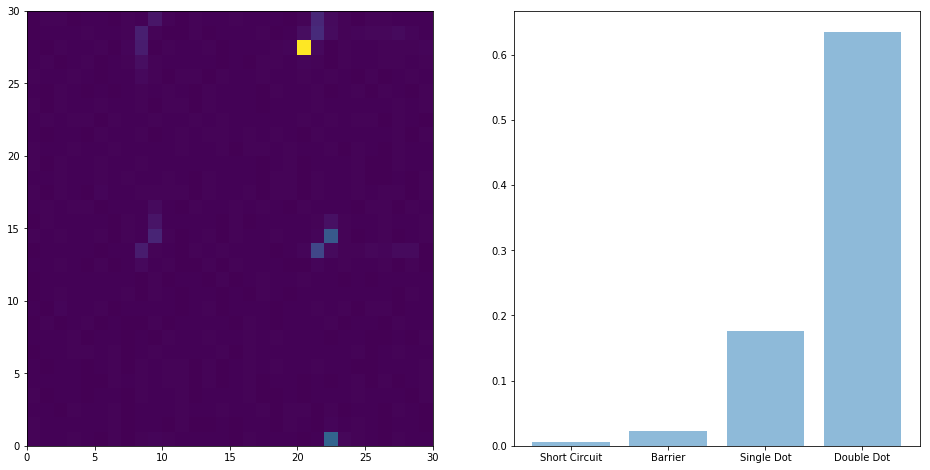

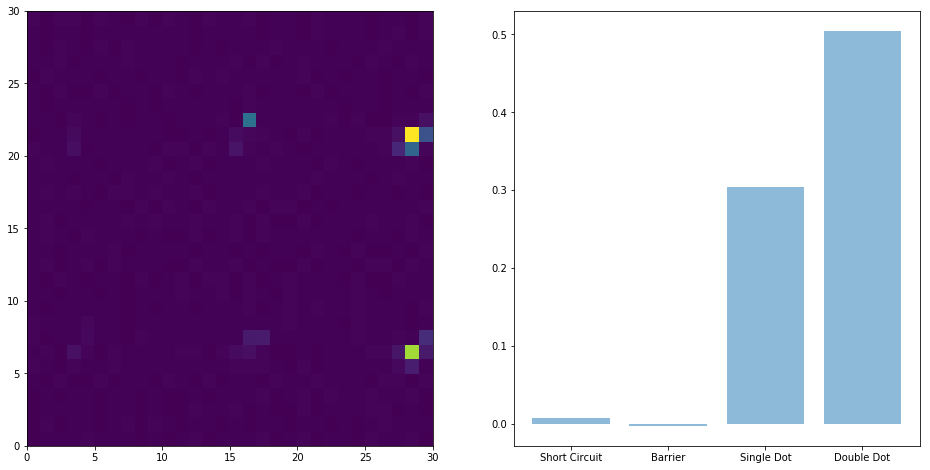

In [29]:
for i in range(len(predictions)):
    plt.figure(i)
    f,axarr = plt.subplots(1,2)
    axarr[0].pcolor(x_test_data[i])
    axarr[1].bar(np.arange(0,4),predictions[i]['prob'],alpha=0.5)
    axarr[1].set_xticks(np.arange(0,4))
    axarr[1].set_xticklabels(["Short Circuit","Barrier","Single Dot","Double Dot"])